# Pix2Pix Generative Adversial Network

![picture](https://phillipi.github.io/pix2pix/images/teaser_v3.png)

![picture](https://www.researchgate.net/publication/362428815/figure/fig1/AS:1184813797130254@1659493030868/Pix2Pix-Conditional-GAN-model-for-paired-image-to-image-translation.png)

## Download Dataset

In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -zxvf maps.tar.gz

## Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

## Preparing CustomDataset
I used val images too when training

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, val_path, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, file_name) for file_name in os.listdir(data_dir)]
        self.val_paths = [os.path.join(val_path, file_name) for file_name in os.listdir(val_path)]
        self.image_paths.extend(self.val_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        pair_img = np.array(Image.open(img_path).convert("RGB"))
        image = pair_img[:,:600]
        target = pair_img[:,600:]

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target
transform_h = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((256, 256)),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                  ])
path = "/content/maps/train"
val_path = "/content/maps/val"
dataset = CustomDataset(path, val_path, transform_h)
batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

### Take a look to Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])


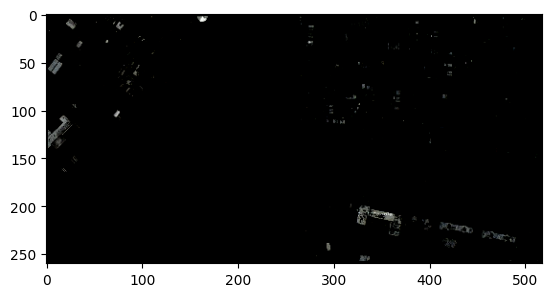

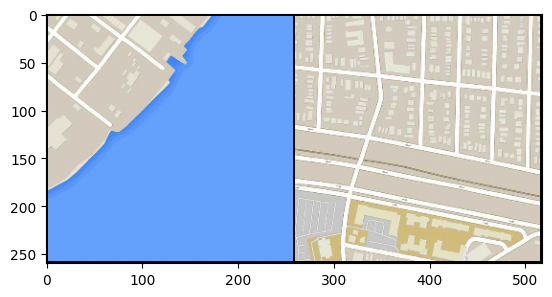

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

x_train, y_train = next(iter(train_loader))
print(x_train.shape, y_train.shape)
imshow(torchvision.utils.make_grid(x_train))
imshow(torchvision.utils.make_grid(y_train))

## Unet Generator Model

In [ ]:
def conv_block(ch_in,ch_out):
    conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out, affine = True),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out, affine = True),
            nn.ReLU(inplace=True)
        )
    return conv

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class UNet(nn.Module):
    def __init__(self,img_ch=3, output_ch=3):
        super(UNet,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

from torchsummary import summary
print(summary(UNet().to("cuda"), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
    InstanceNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
    InstanceNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
   InstanceNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

## PatchGAN Discriminator Model

In [ ]:
import torch.nn as nn
nc = 3
ndf = 32
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc * 2) x 256 x 256``
            nn.Conv2d(nc * 2, ndf * 2, 4, 2, 1, bias=False, padding_mode = "reflect"),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 128 x 128``

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False, padding_mode = "reflect"),
            nn.InstanceNorm2d(ndf * 4, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 64 x 64``

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False, padding_mode = "reflect"),
            nn.InstanceNorm2d(ndf * 8, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf * 8) x 32 x 32``

            nn.Conv2d(ndf * 8, ndf * 16, 4, 1, 1, bias=False, padding_mode = "reflect"),
            nn.InstanceNorm2d(ndf * 16, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf * 16) x 31 x 31``

            nn.Conv2d(ndf*16, 1, 4, 1, 1, padding_mode = "reflect"),
            # state size. ``(ndf * 16) x 30 x 30``
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

from torchsummary import summary
print(summary(Discriminator().to("cuda"), (6, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,144
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,152
   InstanceNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
          Sigmoid-13            [-1, 1, 30, 30]               0
Total params: 2,768,641
Trainable param

## Defining Loss Functions and Optimizers

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
netD = Discriminator().to(device)
netG = UNet(3).to(device)

optimD = optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))

BCE_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

loss_weights = [1, 100]

## Model Training

In [ ]:
num_epoch = 50
path = "/content/maps/train"
dataset = CustomDataset(path, val_path, transform_h)
batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

for epoch in range(num_epoch):
    for i, (image, target) in enumerate(dataloader, 0):
      if torch.cuda.is_available():
        image = image.to(device) #Taking Images
        target = target.to(device)

      ############################
      # (1) Update D network
      ###########################
      netD.zero_grad()

      b_size = image.size(0)
      concated_images = torch.cat([image, target], dim = 1)
      output = netD(concated_images)
      errD_real = BCE_loss(output, torch.ones_like(output))
      errD_real.backward() #calculate the gradients

      ## Train with all-fake batch
      #COMPUTE PROBABILITY OF FAKE OBJECT TO BE FAKE
      fake = netG(image)
      concated_images = torch.cat([image, fake.detach()], dim = 1)
      output = netD(concated_images)
      errD_fake = BCE_loss(output, torch.zeros_like(output))
      errD_fake.backward()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      optimD.step()# update weights and bias

      ############################
      # (2) Update G network
      ###########################
      netG.zero_grad()
      concated_images = torch.cat([image, fake], dim = 1)
      output = netD(concated_images)

      loss1 = BCE_loss(output, torch.ones_like(output))
      loss2 = l1_loss(fake, target)
      errG = loss1 + loss_weights[1] * loss2

      errG.backward()
      D_G_z2 = output.mean().item()
      optimG.step()

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch + 1, num_epoch, i, len(dataloader),
                     errD.item(), errG.item(), D_G_z2))

[1/50][0/549]	Loss_D: 1.4268	Loss_G: 61.2207	D(G(z)): 0.5407
[1/50][50/549]	Loss_D: 0.2493	Loss_G: 18.2213	D(G(z)): 0.1161
[1/50][100/549]	Loss_D: 0.7685	Loss_G: 16.0372	D(G(z)): 0.1840
[1/50][150/549]	Loss_D: 1.7464	Loss_G: 11.4070	D(G(z)): 0.4926
[1/50][200/549]	Loss_D: 1.1501	Loss_G: 10.9990	D(G(z)): 0.4279
[1/50][250/549]	Loss_D: 0.9331	Loss_G: 13.9578	D(G(z)): 0.3284
[1/50][300/549]	Loss_D: 0.9613	Loss_G: 9.6316	D(G(z)): 0.2910
[1/50][350/549]	Loss_D: 0.9254	Loss_G: 11.4940	D(G(z)): 0.3456
[1/50][400/549]	Loss_D: 0.7397	Loss_G: 9.0401	D(G(z)): 0.2617
[1/50][450/549]	Loss_D: 1.1990	Loss_G: 7.5142	D(G(z)): 0.4635
[1/50][500/549]	Loss_D: 1.0161	Loss_G: 11.3055	D(G(z)): 0.3905
[2/50][0/549]	Loss_D: 1.1926	Loss_G: 12.3172	D(G(z)): 0.2581
[2/50][50/549]	Loss_D: 1.1019	Loss_G: 11.3207	D(G(z)): 0.2757
[2/50][100/549]	Loss_D: 0.9723	Loss_G: 13.0482	D(G(z)): 0.2974
[2/50][150/549]	Loss_D: 1.0225	Loss_G: 9.9840	D(G(z)): 0.3079
[2/50][200/549]	Loss_D: 1.0737	Loss_G: 10.9945	D(G(z)): 0.3538
[2

KeyboardInterrupt: ignored

## Evaluation

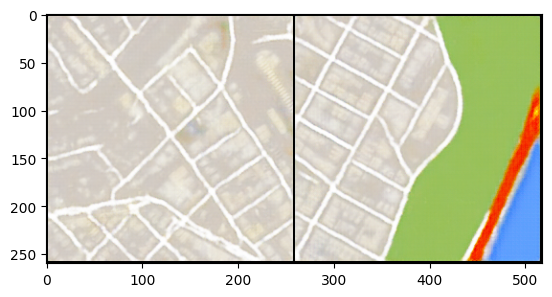

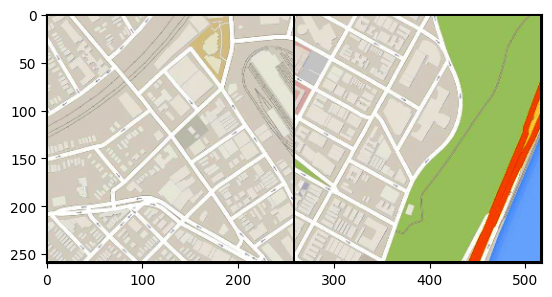

In [ ]:
netG.eval()

x_train, y_train = next(iter(train_loader))
x_train = x_train.to("cuda")

pred = netG(x_train)
pred = torchvision.utils.make_grid(pred)
pred = pred.cpu().detach()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(pred)
imshow(torchvision.utils.make_grid(y_train))

I tested with normal discriminator instead of PatchGAN with 50 Epoch results like this

tensor(1.0000)


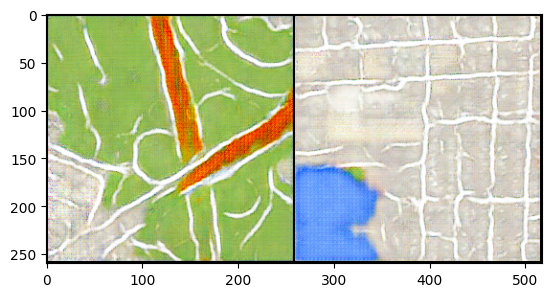

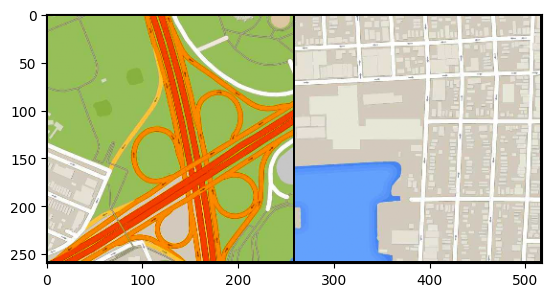

In [ ]:
netG.eval()

x_train, y_train = next(iter(train_loader))
x_train = x_train.to("cuda")

pred = netG(x_train)
pred = torchvision.utils.make_grid(pred)
pred = pred.cpu().detach()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(pred)
imshow(torchvision.utils.make_grid(y_train))